In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, MaxPooling1D, Flatten, Dense, Dropout, Softmax, Concatenate
from keras.layers import BatchNormalization
from keras.optimizers import Adam 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers


%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [4]:
path = 'D:\MLPROJECTS\ecg\mitbih_database'
window_size = 180
maximum_counting = 10000

classes = ['N', 'S', 'V', 'F', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [5]:
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

Processing 100.csv ...
CSV Header: ["'sample #'", "'MLII'", "'V5'"]


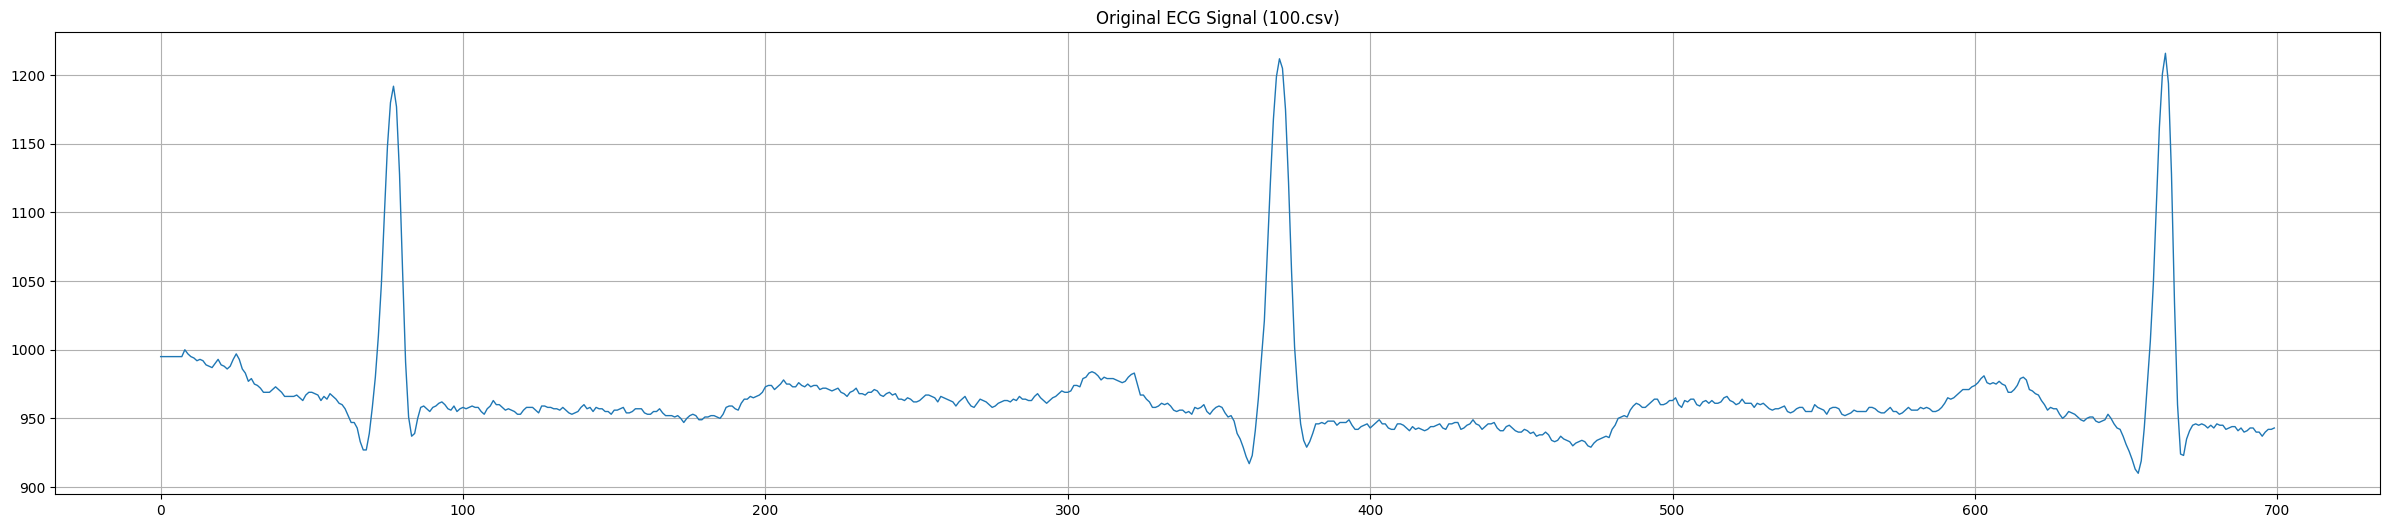

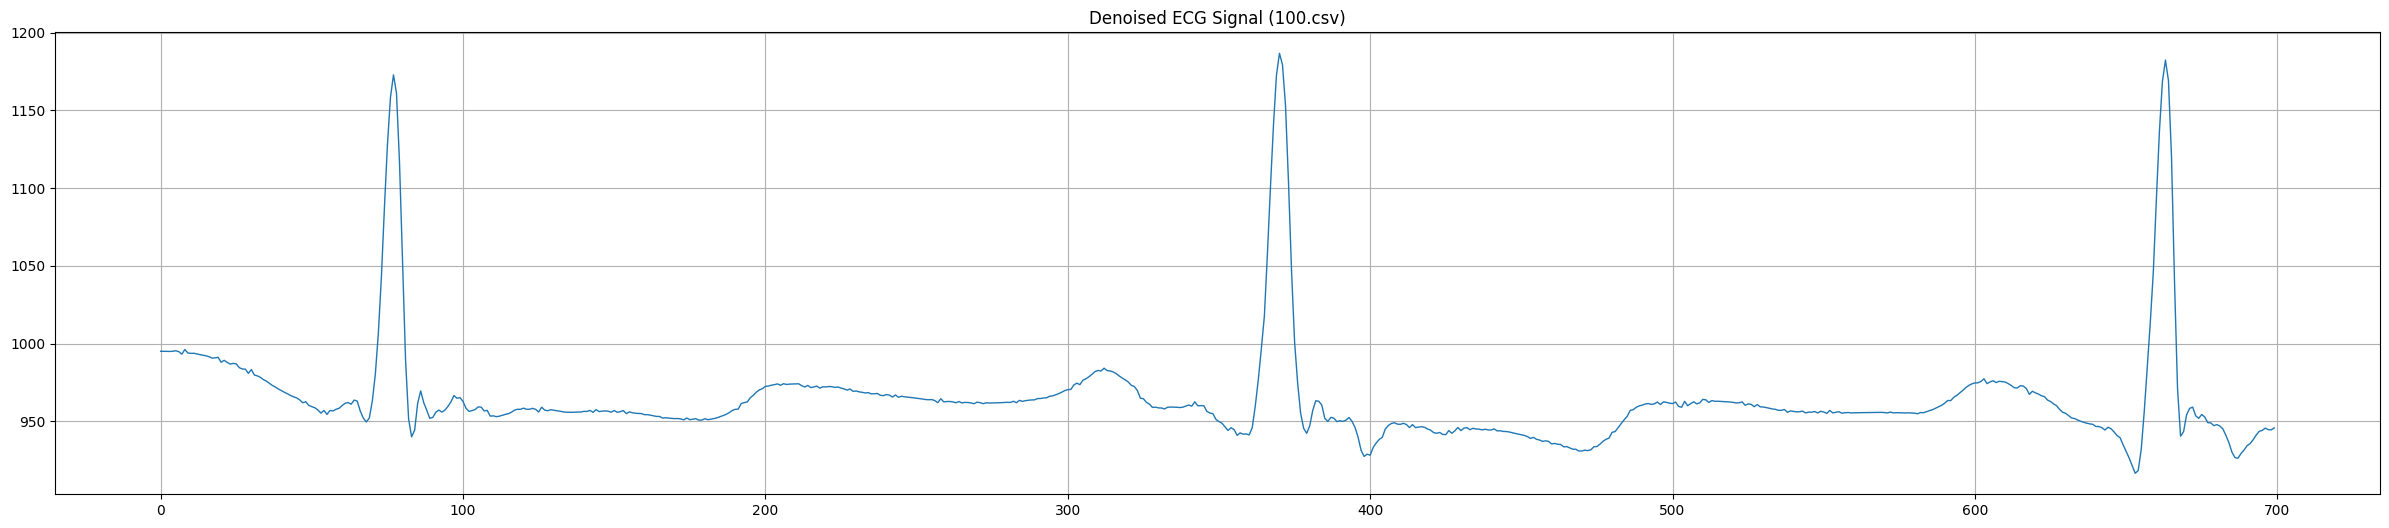

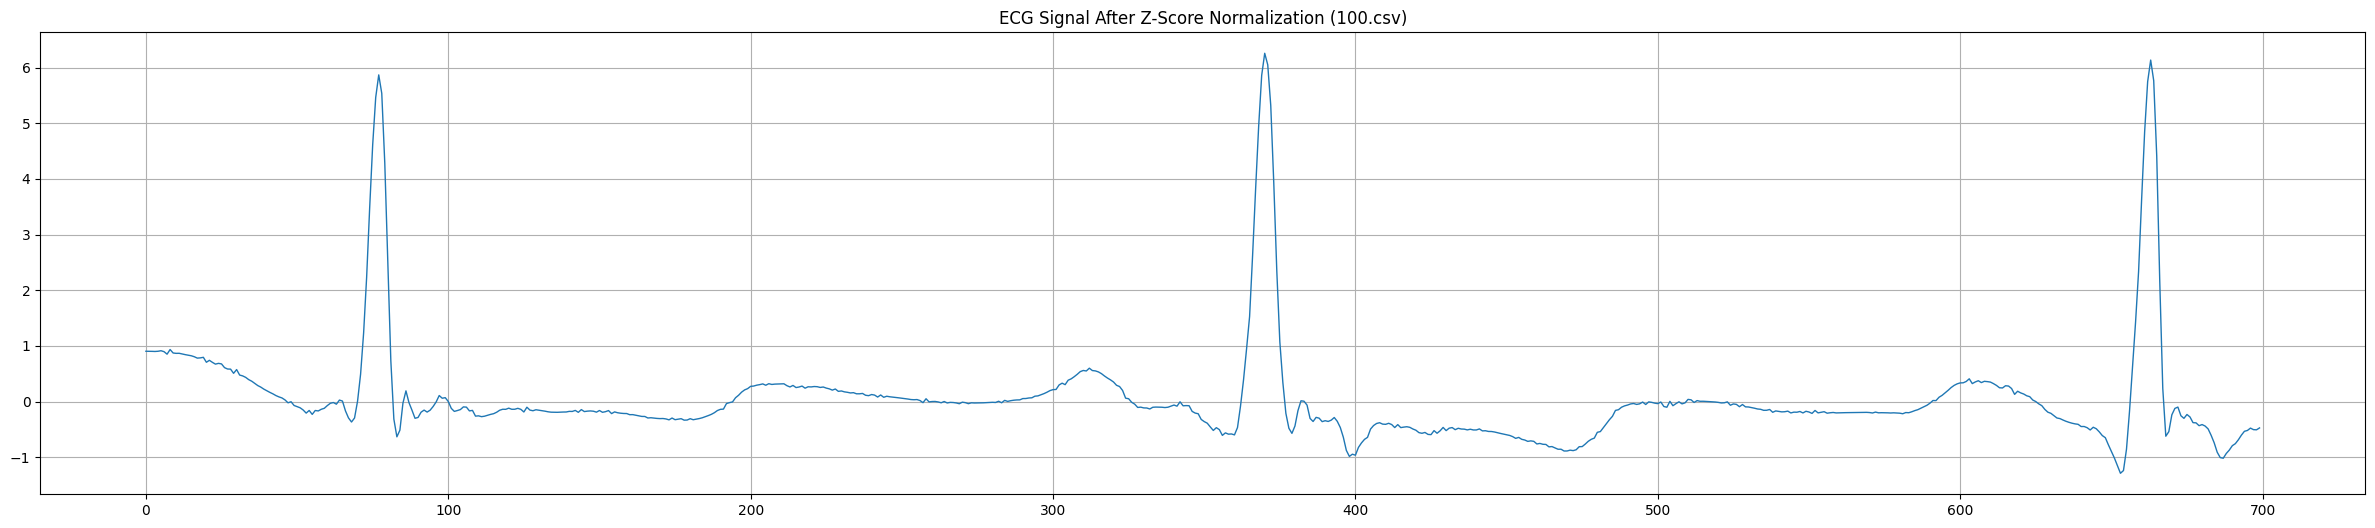

Annotation Sample: ['      Time   Sample #  Type  Sub Chan  Num\tAux\n', '    0:00.050       18     +    0    0    0\t(N\n', '    0:00.214       77     N    0    0    0\n', '    0:01.028      370     N    0    0    0\n', '    0:01.839      662     N    0    0    0\n']


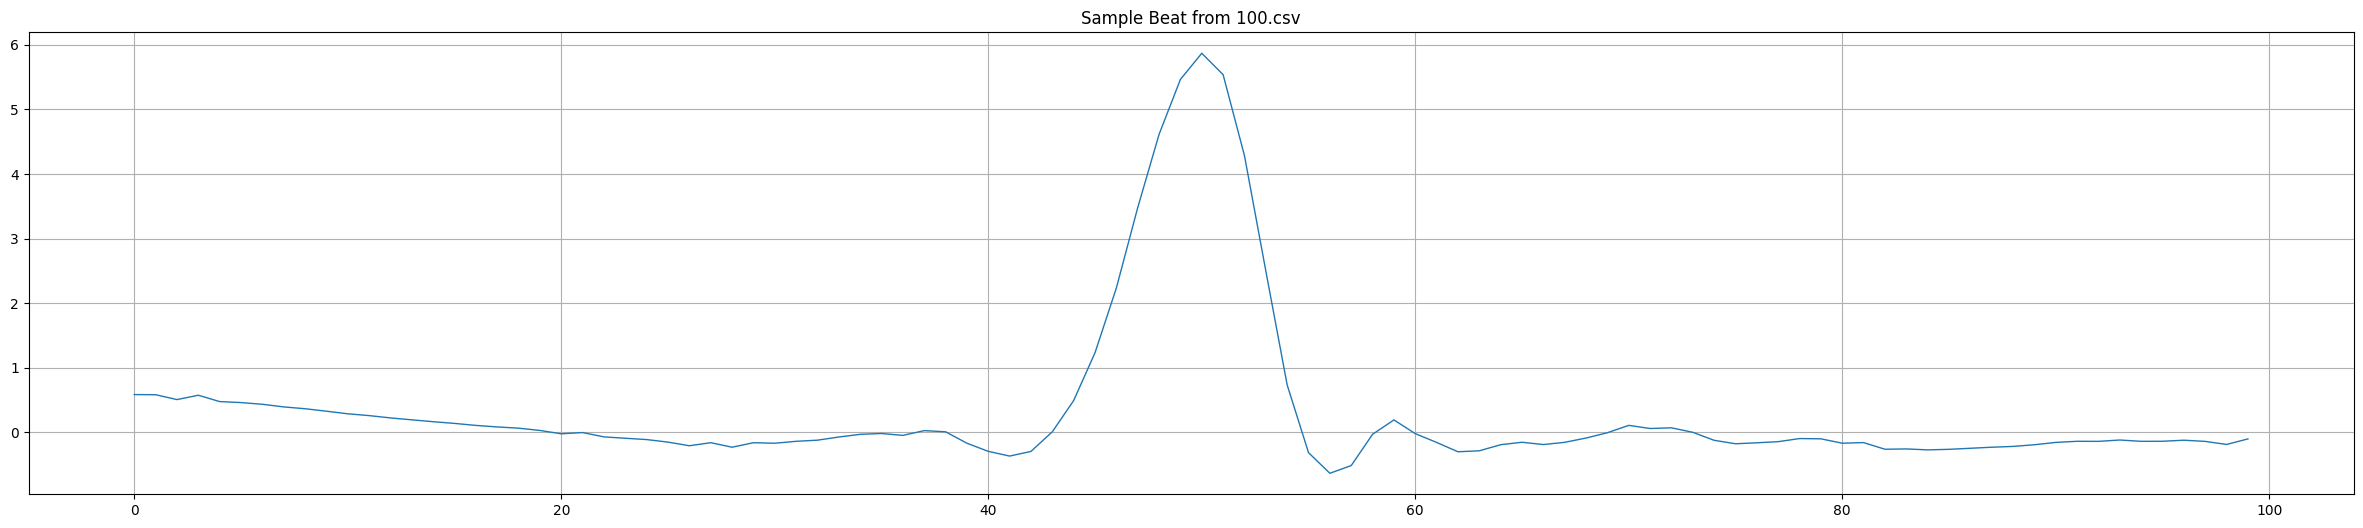

Processing 101.csv ...
CSV Header: ["'sample #'", "'MLII'", "'V1'"]
Annotation Sample: ['      Time   Sample #  Type  Sub Chan  Num\tAux\n', '    0:00.019        7     +    0    0    0\t(N\n', '    0:00.231       83     N    0    0    0\n', '    0:01.100      396     N    0    0    0\n', '    0:01.975      711     N    0    0    0\n']
Processing 102.csv ...
CSV Header: ["'sample #'", "'V5'", "'V2'"]
Annotation Sample: ['      Time   Sample #  Type  Sub Chan  Num\tAux\n', '    0:00.189       68     +    0    0    0\t(P\n', '    0:00.378      136     /    0    0    0\n', '    0:01.139      410     /    0    0    0\n', '    0:01.936      697     /    0    0    0\n']
Processing 103.csv ...
CSV Header: ["'sample #'", "'MLII'", "'V2'"]
Annotation Sample: ['      Time   Sample #  Type  Sub Chan  Num\tAux\n', '    0:00.058       21     +    0    0    0\t(N\n', '    0:00.736      265     N    0    0    0\n', '    0:01.597      575     N    0    0    0\n', '    0:02.433      876     N    0    0 

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Ensure PyWavelets is installed
from scipy import stats

# Function to denoise signals using wavelet transform
def denoise(signal):
    coeffs = pywt.wavedec(signal, 'db4', level=4)  # Decompose signal
    coeffs[1:] = [pywt.threshold(c, np.std(c)/2, mode='soft') for c in coeffs[1:]]  # Soft thresholding
    return pywt.waverec(coeffs, 'db4')  # Reconstruct signal

# Define database directory
database_dir = r"D:\MLPROJECTS\ecg\mitbih_database"

# Manually specify annotation file paths
annotation_paths = {
    "100.csv": r"D:\MLPROJECTS\ecg\mitbih_database\100annotations.txt",
    "101.csv": r"D:\MLPROJECTS\ecg\mitbih_database\101annotations.txt",
    "102.csv": r"D:\MLPROJECTS\ecg\mitbih_database\102annotations.txt",
    "103.csv": r"D:\MLPROJECTS\ecg\mitbih_database\103annotations.txt",
    "104.csv": r"D:\MLPROJECTS\ecg\mitbih_database\104annotations.txt",
    "234.csv": r"D:\MLPROJECTS\ecg\mitbih_database\234annotations.txt"
    # Add more if needed
}

# Get all CSV files (ECG signal files)
csv_files = list(annotation_paths.keys())  # Only use files that have annotation paths

# Initialize dataset lists
X = []+
y = []
count_classes = [0] * 10  # Assuming 10 possible arrhythmia classes
window_size = 50  # Adjust window size as needed
classes = ["N", "V", "A", "L", "R", "B", "E", "F", "/", "f"]  # Example arrhythmia classes

# Process each record in the database
for csv_file in csv_files:
    csv_path = os.path.join(database_dir, csv_file)
    annotation_path = annotation_paths[csv_file]  # Use absolute annotation path

    # Ensure both signal and annotation files exist
    if not os.path.exists(csv_path):
        print(f"Skipping {csv_file}: Signal file not found!")
        continue
    if not os.path.exists(annotation_path):
        print(f"Skipping {csv_file}: Annotation file not found!")
        continue

    print(f"Processing {csv_file} ...")  # Debugging

    # Read CSV file (ECG signals)
    signals = []
    with open(csv_path, 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        header = next(spamreader)  # Skip header and check format
        print(f"CSV Header: {header}")  # Debugging

        for row in spamreader:
            try:
                signals.append(float(row[1]))  # Convert to float for accuracy
            except ValueError:
                print(f"Skipping row: {row}")  # Handle conversion errors

    if not signals:
        print(f"Skipping {csv_file}: No valid signal data!")
        continue

    # Plot the original ECG wave (only for the first file)
    if csv_file == csv_files[0]:
        plt.title(f"Original ECG Signal ({csv_file})")
        plt.plot(signals[:700])
        plt.show()

    # Apply denoising
    signals = denoise(signals)

    # Plot the denoised ECG wave
    if csv_file == csv_files[0]:
        plt.title(f"Denoised ECG Signal ({csv_file})")
        plt.plot(signals[:700])
        plt.show()

    # Apply Z-score normalization
    signals = stats.zscore(signals)

    # Plot the normalized ECG wave
    if csv_file == csv_files[0]:
        plt.title(f"ECG Signal After Z-Score Normalization ({csv_file})")
        plt.plot(signals[:700])
        plt.show()

    # Read annotations (R positions and Arrhythmia class)
    example_beat_printed = False
    with open(annotation_path, 'r') as fileID:
        data = fileID.readlines()

        print(f"Annotation Sample: {data[:5]}")  # Debugging

        for d in range(1, len(data)):  # Skip header
            splitted = list(filter(None, data[d].strip().split()))  # Remove empty entries
            if len(splitted) < 3:
                continue  # Skip invalid lines

            try:
                pos = int(splitted[1])  # Sample ID
                arrhythmia_type = splitted[2]  # Arrhythmia type
            except ValueError:
                continue  # Skip malformed data

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1

                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size : pos + window_size]  # Extract beat segment

                    # Plot an example beat (only once)
                    if csv_file == csv_files[0] and not example_beat_printed:
                        plt.title(f"Sample Beat from {csv_file}")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# Print dataset shape
print("\nTotal ECG records processed:", len(csv_files))
print("Shape of X (Beats Extracted):", np.shape(X))
print("Shape of y (Arrhythmia Labels):", np.shape(y))


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X))

(13320, 101)


0    9142
1      10
2      38
8    3408
9     722
Name: count, dtype: int64


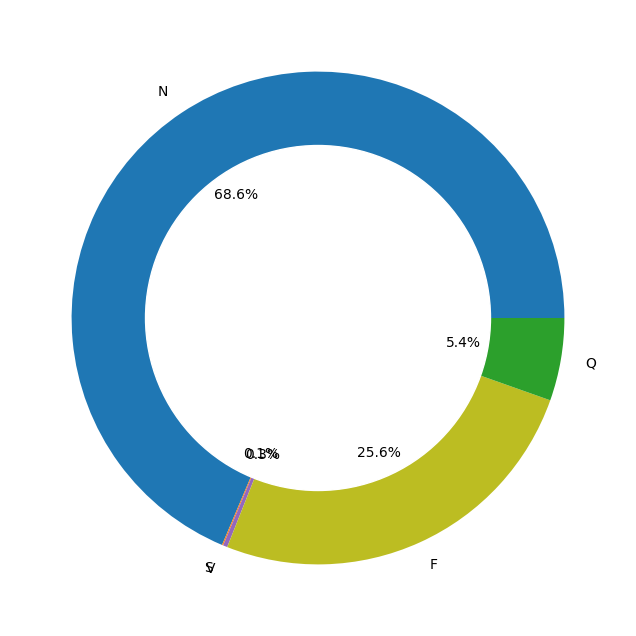

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert X into a DataFrame (without labels)
X_train_df = pd.DataFrame(X)

# Convert y into a DataFrame for counting class occurrences
y_df = pd.Series(y)

# Count occurrences of each class in y
per_class = y_df.value_counts().sort_index()

# Print class distribution
print(per_class)

# Plot a pie chart
plt.figure(figsize=(8, 8))  # Adjust size
my_circle = plt.Circle((0, 0), 0.7, color='white')

# Labels for each arrhythmia class (adjust as needed)
labels = ['N', 'S', 'V', 'F', 'Q']  # Ensure these match your actual class labels

# Define colors
colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green']

# Ensure labels and counts align
plt.pie(per_class, labels=labels[:len(per_class)], colors=colors[:len(per_class)], autopct='%1.1f%%')

# Add the circle for a donut chart effect
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the chart
plt.show()


In [10]:
def create_dataframe():
    data = {'column1': [1, 2, 3], 'column2': [4, 5, 6]}
    return pd.DataFrame(data)

df_3 = create_dataframe()


In [11]:
from sklearn.utils import resample

# Check the size before upsampling
print(f"Original size of df_3: {len(df_3)}")

if len(df_3) > 0:  # Ensure df_3 is not empty
    df_3_upsample = resample(df_3, replace=True, 
                             n_samples=min(5000, len(df_3) * 2),  # Prevent oversampling too much
                             random_state=124)
else:
    print("Warning: df_3 is empty! Skipping resampling.")
    df_3_upsample = df_3  # Keep it unchanged if empty

# Print the new size after upsampling
print(f"New size of df_3_upsample: {len(df_3_upsample)}")


Original size of df_3: 3
New size of df_3_upsample: 6


100
0.0    9142
8.0    3408
9.0     722
2.0      38
1.0      10
Name: count, dtype: int64


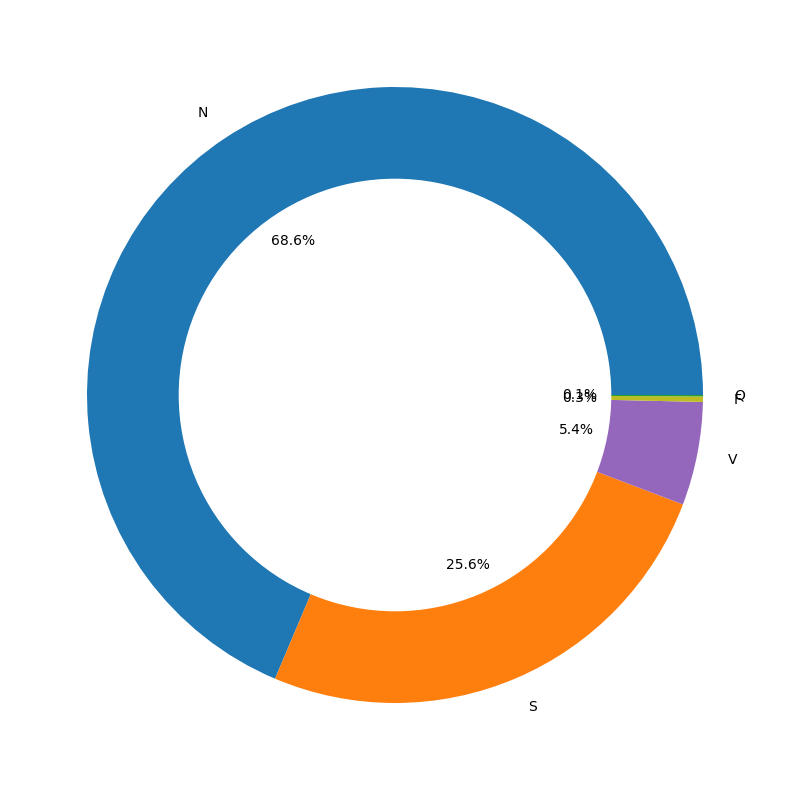

In [12]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (10656, 101)
X_test  :  (2664, 101)


In [14]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(10656, 10) (2664, 10)


In [15]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(10656, 100, 1) (2664, 100, 1)


In [16]:
model1 = Sequential()

model1.add(Conv1D(filters=16, kernel_size=11, strides=1, padding='same' , activation = 'relu', input_shape=(360,1)))
model1.add(MaxPooling1D(pool_size=5, strides=2))
model1.add(Conv1D(filters=32, kernel_size=13, strides=1, padding='same' , activation = 'relu'))
model1.add(MaxPooling1D(pool_size=5, strides=2))
model1.add(Conv1D(filters=64, kernel_size=15, strides=1, padding='same' , activation = 'relu'))
model1.add(MaxPooling1D(pool_size=5, strides=2))
model1.add(Conv1D(filters=128, kernel_size=17, strides=1, padding='same' , activation = 'relu'))
model1.add(MaxPooling1D(pool_size=5, strides=2))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(5, activation='softmax'))
model1.summary()

c:\Users\jiten\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 16)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 178, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 178, 32)        │         6,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 87, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 87, 64)         │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 42, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 42, 128)        │       139,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2432)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       243,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,661 (1.62 MB)

 Trainable params: 425,661 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [18]:
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)
print("test_x shape:", test_x.shape)
print("test_y shape:", test_y.shape)


train_x shape: (10656, 100, 1)
train_y shape: (10656, 10)
test_x shape: (2664, 100, 1)
test_y shape: (2664, 10)


In [19]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Force TensorFlow to use only the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Verify that only CPU is used
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Load and preprocess dataset (Example: CIFAR-10)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

# Define a simple CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on CPU
history = model.fit(x_train, y_train, epochs=60, batch_size=32,
                    validation_data=(x_test, y_test))

# Evaluate performance
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)


Num GPUs Available: 0
Epoch 1/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.3883 - loss: 1.6629 - val_accuracy: 0.5976 - val_loss: 1.1316
Epoch 2/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.6123 - loss: 1.0926 - val_accuracy: 0.6586 - val_loss: 0.9802
Epoch 3/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6861 - loss: 0.8944 - val_accuracy: 0.6947 - val_loss: 0.8913
Epoch 4/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.7310 - loss: 0.7694 - val_accuracy: 0.6989 - val_loss: 0.8643
Epoch 5/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.7606 - loss: 0.6809 - val_accuracy: 0.7113 - val_loss: 0.8434
Epoch 6/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.7884 - loss: 0.6047 - val_accuracy: 0.7200 - val_loss: 0.8278
Epoch 7/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.8155 - loss: 0.5299 - val_accuracy: 0.7291 - val_loss: 0.8427
Epoch 8/60
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/ste

Epoch 1/60


c:\Users\jiten\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1667/1667 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8725 - loss: 0.4299 - val_accuracy: 0.9607 - val_loss: 0.1331
Epoch 2/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9659 - loss: 0.1099 - val_accuracy: 0.9717 - val_loss: 0.0914
Epoch 3/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9779 - loss: 0.0702 - val_accuracy: 0.9707 - val_loss: 0.0936
Epoch 4/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9842 - loss: 0.0504 - val_accuracy: 0.9731 - val_loss: 0.0844
Epoch 5/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9861 - loss: 0.0423 - val_accuracy: 0.9743 - val_loss: 0.0880
Epoch 6/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9895 - loss: 0.0322 - val_accuracy: 0.9737 - val_loss: 0.0972
Epoch 7/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9917 - loss: 0.0264 - val_accuracy: 0.9716 - val_loss: 0.0968
Epoch 8/60
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9935 - loss: 0.0187 - val_accurac

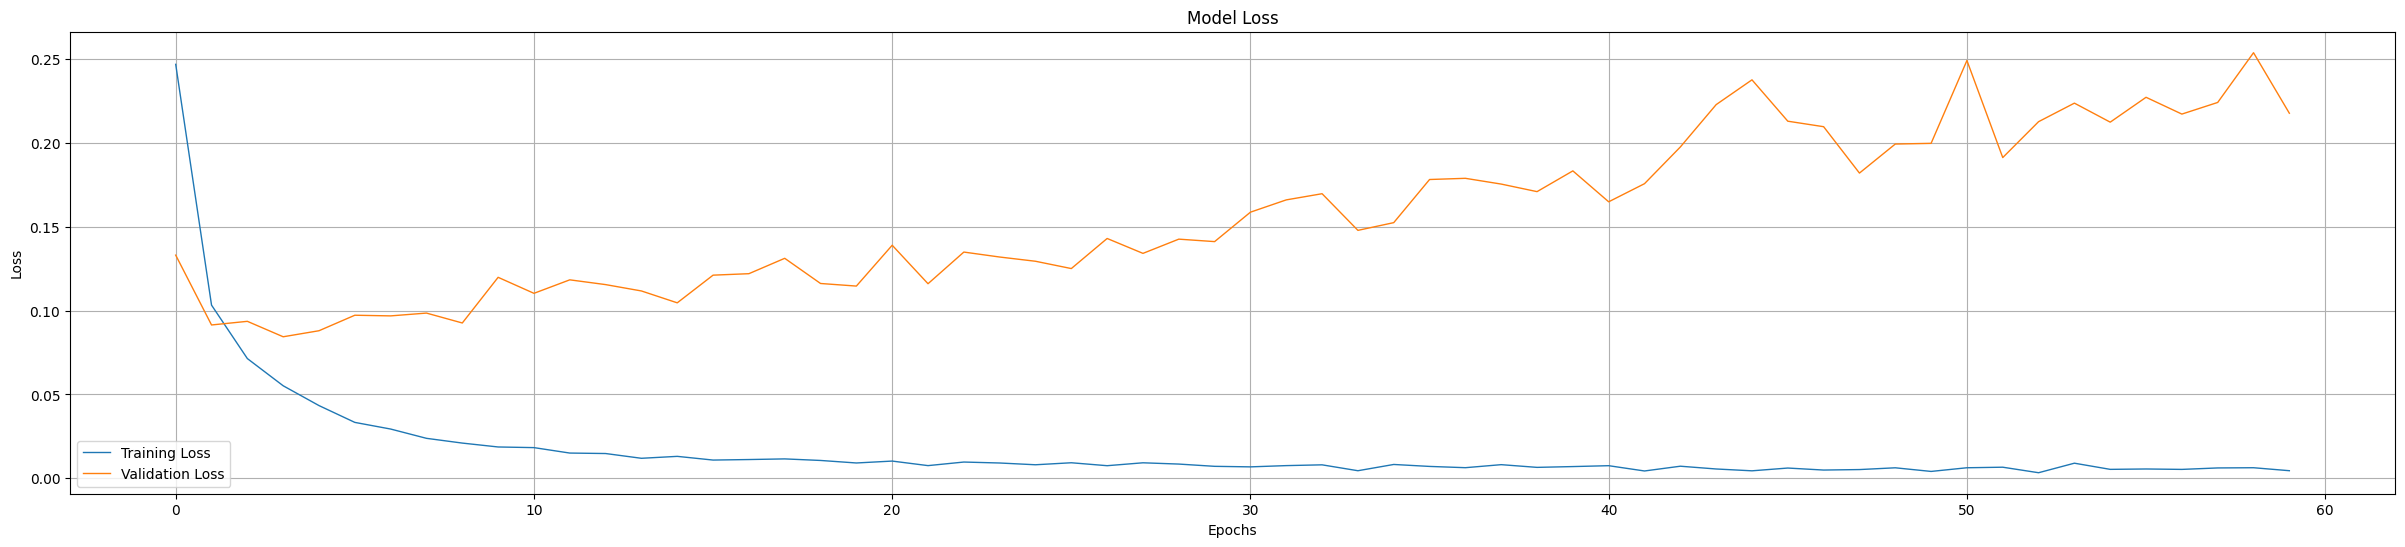

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist  # Example dataset

# 1️⃣ Load Dataset (Replace with your actual dataset)
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# 2️⃣ Preprocess Data
train_x = train_x.reshape(train_x.shape[0], -1).astype('float32') / 255.0  # Flatten and normalize
test_x = test_x.reshape(test_x.shape[0], -1).astype('float32') / 255.0
train_y = to_categorical(train_y, num_classes=10)  # Convert labels to categorical
test_y = to_categorical(test_y, num_classes=10)

# 3️⃣ Define Model
model1 = Sequential([
    Dense(128, activation='relu', input_shape=(train_x.shape[1],)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4️⃣ Train Model
history1 = model1.fit(
    train_x, train_y,
    batch_size=36,
    epochs=60,
    verbose=1,
    validation_data=(test_x, test_y)
)

# 5️⃣ Plot Training & Validation Loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

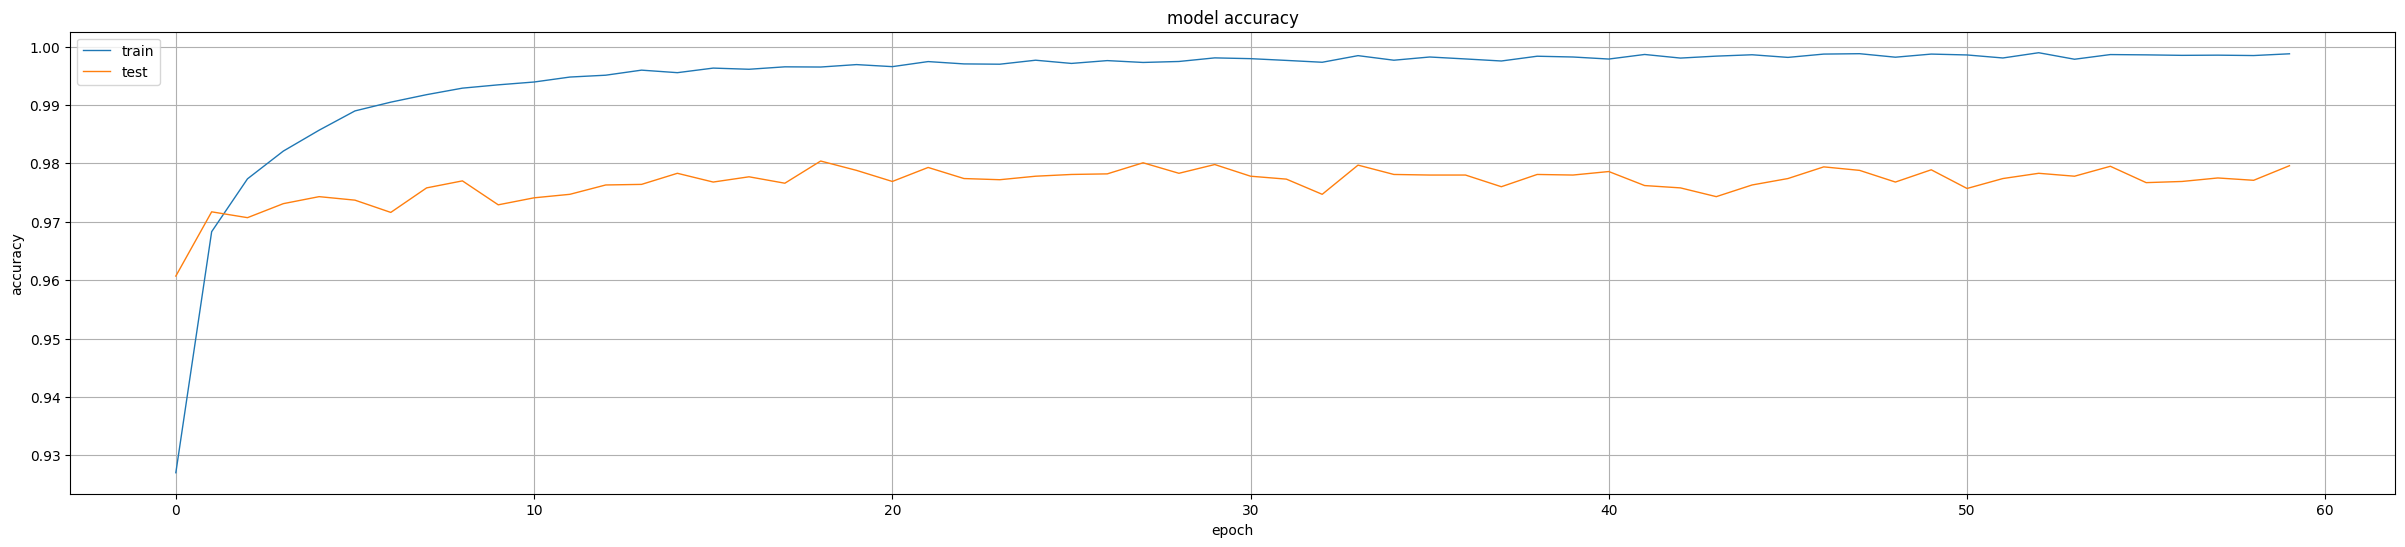

In [21]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model1.predict(test_x)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.00000000e+00, 7.13956921e-23, 1.43410858e-28, ...,
        1.00000000e+00, 6.51496732e-33, 1.79814610e-18],
       [4.80079933e-31, 1.14510864e-35, 1.00000000e+00, ...,
        0.00000000e+00, 3.77131206e-23, 0.00000000e+00],
       [1.91223875e-28, 1.00000000e+00, 1.02513376e-21, ...,
        7.84267361e-19, 1.06680827e-14, 1.00166581e-28],
       ...,
       [0.00000000e+00, 1.41413242e-29, 3.34448140e-34, ...,
        1.22024259e-25, 8.17844995e-28, 2.26915069e-21],
       [9.50461925e-30, 7.20994083e-29, 0.00000000e+00, ...,
        0.00000000e+00, 1.57599667e-22, 0.00000000e+00],
       [4.48189048e-32, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.11248726e-37, 0.00000000e+00]], dtype=float32)

In [23]:
score = model1.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9758 - loss: 0.2648
Test Loss: 0.2177480012178421
Test accuracy: 0.9796000123023987


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


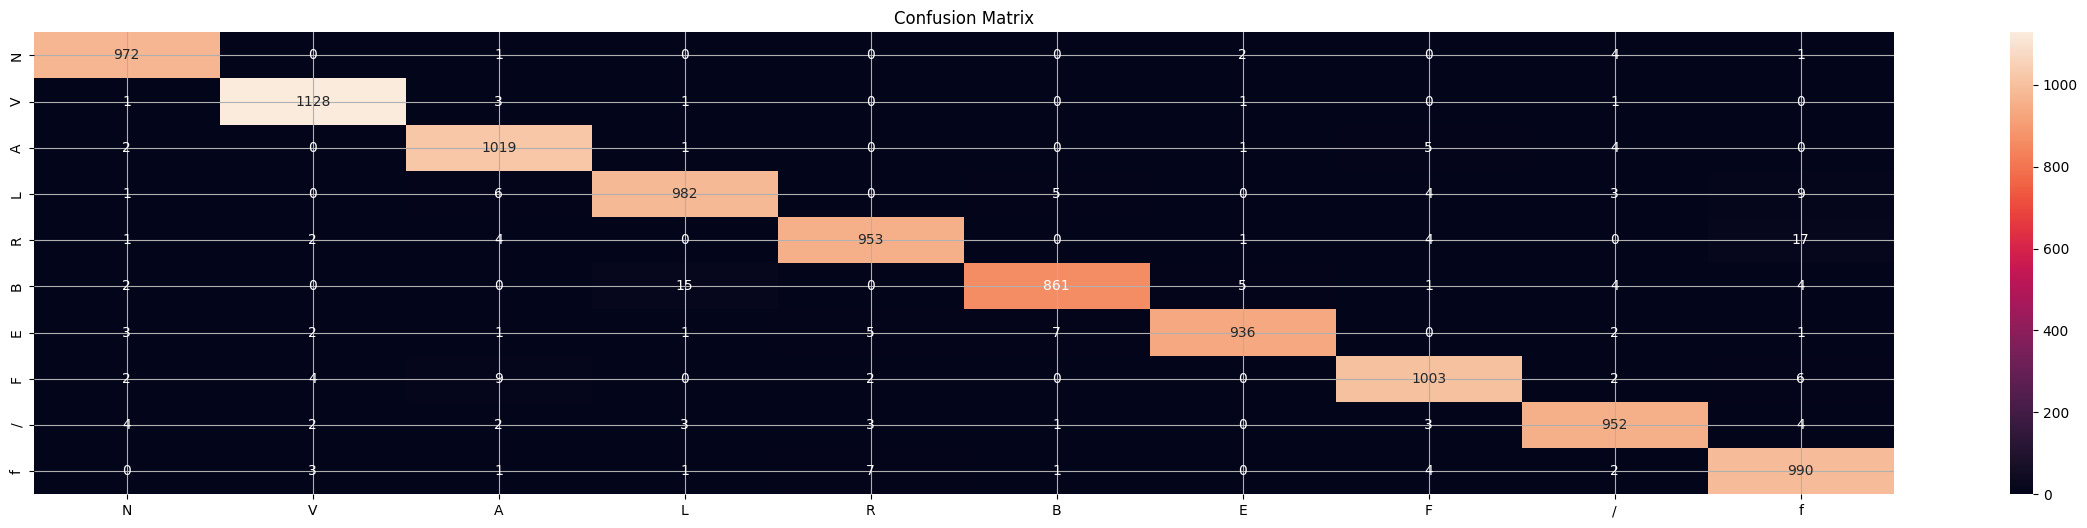

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=model1.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
ax=plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat, annot=True,fmt='d',ax=ax)
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.savefig('cm')

In [25]:
from sklearn.metrics import classification_report

cf = classification_report(y_true, prediction, target_names=classes,digits=4)
print(cf)

              precision    recall  f1-score   support

           N     0.9838    0.9918    0.9878       980
           V     0.9886    0.9938    0.9912      1135
           A     0.9742    0.9874    0.9808      1032
           L     0.9781    0.9723    0.9752      1010
           R     0.9825    0.9705    0.9764       982
           B     0.9840    0.9652    0.9745       892
           E     0.9894    0.9770    0.9832       958
           F     0.9795    0.9757    0.9776      1028
           /     0.9774    0.9774    0.9774       974
           f     0.9593    0.9812    0.9701      1009

    accuracy                         0.9796     10000
   macro avg     0.9797    0.9792    0.9794     10000
weighted avg     0.9797    0.9796    0.9796     10000



In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess data (assuming X, y are already prepared)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape input for LSTM [samples, time steps, features]
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Encode labels properly
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))  # Ensure correct class count

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(32),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train model
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

# Evaluate model
loss, accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {accuracy * 100:.2f}%')
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/50


c:\Users\jiten\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


333/333 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.8693 - loss: 0.4624 - val_accuracy: 0.9520 - val_loss: 0.1579
Epoch 2/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 103ms/step - accuracy: 0.9663 - loss: 0.1294 - val_accuracy: 0.9827 - val_loss: 0.0631
Epoch 3/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.9778 - loss: 0.0812 - val_accuracy: 0.9805 - val_loss: 0.0613
Epoch 4/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 34s 102ms/step - accuracy: 0.9809 - loss: 0.0722 - val_accuracy: 0.9869 - val_loss: 0.0464
Epoch 5/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9848 - loss: 0.0525 - val_accuracy: 0.5687 - val_loss: 1.8227
Epoch 6/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 47s 141ms/step - accuracy: 0.9829 - loss: 0.0575 - val_accuracy: 0.9902 - val_loss: 0.0285
Epoch 7/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - accuracy: 0.9814 - loss: 0.0622 - val_accuracy: 0.9884 - val_loss: 0.0308
Epoch 8/50
333/333 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9832 - loss: 0.0542 - val

In [27]:
import joblib
import tensorflow as tf

# Save LSTM Model
MODEL_PATH = "lstm_model.h5"
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# Save Scaler
SCALER_PATH = "scaler.pkl"
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to {SCALER_PATH}")

# Save Label Encoder
ENCODER_PATH = "encoder.pkl"
joblib.dump(encoder, ENCODER_PATH)
print(f"Encoder saved to {ENCODER_PATH}")


Model saved to lstm_model.h5
Scaler saved to scaler.pkl
Encoder saved to encoder.pkl


In [28]:
print(model.input_shape) 

(None, 101, 1)


In [29]:
print(encoder.classes_)

[0 1 2 8 9]
